In [7]:
"""Model a ball of gas with a polytropic equation of state."""

import warnings
import scipy
import numpy as np
import astropy.constants as const
import astropy.units as u
from astropy.table import QTable
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class Polytrope:
    """Model with a polytropic equation of state.
    P = K ρˠ
    Here, the polytropic exponent γ is related to the polytropic
    index n by γ = 1 + 1/n.
    Parameters
    ----------
    K : `~astropy.units.Quantity`
        Proportionality constant.  Should have appropriate units.
    gamma : float
        Polytropic exponent.
    """

    def __init__(self, k, gamma):
        self.k = k
        self.gamma = gamma
        self._rho_c = None
        self._r_unit = None
        self._condition = None
        self._mr_scale = None
#         self.result = None


    def integrate(self, rho_c, r, condition=None):
        """Integrate MC and HE from a given starting density.
        Parameters
        ----------
        rho_c : `~astropy.units.Quantity`
            Central density to start integration at.
        r : `~astropy.units.Quantity`
            Radii at which to evaluate the integral.  Radii beyond the
            stopping condition will not be used.
        condition : callable, optional
            Function that tells when to stop integrating.  Will be pass on
            ``r, mr, rho`` and should return a value that changes sign when
            the integration should stop. By default, uses the density, i.e.,
            integration will stop once the density becomes negative.
        Returns
        -------
        result : `~astropy.table.QTable`
            A table with columns ``r, mr, rho, p`` evaluated at the given
            radii, as well as at the location where the integration stopped
            (if that was within the range of input radii).
        """
        self._rho_c = rho_c
        self._r_unit = r.unit
        self._condition = condition
        # It is easier to integrate with variables of the same order
        # of magnitude, so work relative to rho_c and an estimate
        # of the total mass (not critical to have it exactly right).
        self._mr_scale = (self._rho_c * (r.max() / 2) ** 3).to(u.Msun)
        # scipy integration routine cannot handle Quantity, so use
        # scaled values and multiply with scales as needed in .structure_eqs().
        
        sol = solve_ivp(
            self.structure_eqs,  # Function that calculates derivatives.
            t_span=r[[0, -1]].value,  # Range within which to integrate.
            y0=[0, 1],  # Initial values: Mr=0, rho/rho_c=1.
            t_eval=r.value,  # Evaluate at chosen points.
            events=self.terminate,  # Terminate when ρ<0 (or condition < 0).
        )
        if not sol.success:
            warnings.warn('Solver did not succeed.')
        # Put physical scales back on.
        r_sol = sol.t * self._r_unit
        mr = sol.y[0] * self._mr_scale
        rho = sol.y[1] * self._rho_c
        result = QTable([r_sol, mr, rho], names=['r', 'mr', 'rho'])
        if len(sol.t_events[0]):
            # If density got to 0, add a final row for that.
            assert len(sol.t_events) == 1 and len(sol.t_events[0]) == 1
            result.insert_row(
                len(result),
                dict(r=sol.t_events[0][0] * self._r_unit,
                     mr=sol.y_events[0][0, 0] * self._mr_scale,
                     rho=max(sol.y_events[0][0, 1], 0) * self._rho_c))
        # Add column with implied pressure (from polytropic EoS).
        result['p'] = (self.k * result['rho'].si**self.gamma).to(u.Pa)
        t = mu * const.m_p * result['p'] / (result['rho'].si * const.k_B)
        result['energy'] = self.energy_eq(result['rho'].to(u.g/u.cm**3).value,t.value)
        return result

    def structure_eqs(self, r, par):
        """Mass conservation and hydrostatic equilibrium (for internal use).
        dMᵣ/dr = 4πr²ρ
        dP/dr = -GMᵣρ/r²
        Latter transformed to dρ/dr by getting dP/dρ from EoS.
        Parameters
        ----------
        r : float
            Radius in units of ``self._r_unit``.
        par : list of float
            Current parameters: scaled enclosed mass and density.
        Returns
        -------
        derivatives : list of float
            Derivatives of scaled enclosed mass and density with radius.
        """
        if r == 0 or par[1] <= 0:
            return [0, 0]
        # Multiply with physical scale/uit.
        r = r * self._r_unit
        mr = par[0] * self._mr_scale
        rho = par[1] * self._rho_c
        # Mass conservation.
        dmr_dr = 4 * np.pi * r**2 * rho
        # Hydrostatic equibrium, use in terms of density.
        dp_dr = -const.G * mr / r**2 * rho
        # For polytropic equation of state, dP/dρ=γKρˠ⁻¹.
        dp_drho = self.k * rho ** (self.gamma - 1.) * self.gamma
        drho_dr = dp_dr / dp_drho
        # Temperature for energy equation
        
        # Bring back to correct unit and return just the values.
        return [(dmr_dr / self._mr_scale).to_value(1 / self._r_unit),
                (drho_dr / self._rho_c).to_value(1 / self._r_unit)]

    def terminate(self, r, par):
        """Stopping condition (for internal use).
        Returns the scaled density if no explicit ``condition`` was used in
        the call to ``integrate()``.  Otherwise, calls ``condition`` with
        ``r, mr, rho`` in physical units.
        Parameters
        ----------
        r : float
            Radius in units of ``self._r_unit``.
        par : list of float
            Current parameters: scaled enclosed mass and density.
        Returns
        -------
        value : float
            The value which, if it changes sign, signals that integration
            should stop.
        """
        if self._condition is None:
            # By default, just terminate if the density becomes less than 0.
            return par[1]

        condition = self._condition(
            r,
            mr=par[0]*self._mr_scale,
            rho=par[1]*self._rho_c
        )
        # Cannot pass back units, so get the number for any quantity output.
        return getattr(condition, 'value', condition)

    # Signal to solve_ivp to stop integration if the termination signal
    # changes sign.

    def energy_eq(self, rho, T):
        """KWW Eq.18.63. Written by Shuhan Zheng"""
        edkt = 5.92 * 10 **-3 * (rho/(T*10**(-7))**3)**0.5
        X = 1 # Kept as 1 because we are assuming ideal
        f_gg = np.exp(edkt)
        g_11 = 1 + 3.82 * T / 10**9 + 1.51 * (T / 10 ** 9) ** 2 + 0.144 * (T/10**9) ** 3 - 0.0114 * (T/10**9) ** 4
        e_pp = 2.57 * 10**4 * f_gg * g_11 * rho * X**2 * (T / 10 ** 9)** (-2/3) * np.exp(-3.381 * T**(-1/3))

        return e_pp

    terminate.terminal = True

In [50]:
def p_gt_p_ism(r, mr, rho):
    return k*rho**gamma - p_ism

def integrate_list(numbers):
    # Convert the input list to a NumPy array
    numbers = np.array(numbers)
    # Use cumulative_trapezoidal to integrate the list of numbers
    integrated_numbers = scipy.integrate._quadrature.cumulative_trapezoid(numbers)
    # Return the integrated values as a list
    return list(integrated_numbers)

def effective_T(radius, luminosity):
    return (luminosity * u.W/(4*np.pi*(radius.si)**2 * const.sigma_sb))**(1/4)

# 0.3 M_sun

In [53]:
m = 0.3*u.M_sun
r = 0.33*u.R_sun
mu = 1/2
rho_c = 5.99071*m / (4/3*np.pi*r**3).si
pc = 0.77014*const.G*m**2/r**4 # Ideal gas law
gamma = 5/3 # Since n=1.5
k = pc / (rho_c ** gamma).si

poly = Polytrope(k=k, gamma=gamma)
p_ism = 2.5e-12 * u.Pa

result1 = poly.integrate(rho_c, np.linspace(0, 0.33, 201)*u.R_sun, condition=p_gt_p_ism)
t1 = mu * const.m_p * result1['p'] / (result1['rho'].si * const.k_B)
energy1 = result1["energy"][:-15]

T1 = (mu * const.m_p * result1["p"] / (result1["rho"] * const.k_B)).si

dLdr1 = []
for i in range(len(energy1)):
    dLdr1.append((4*np.pi*result1["r"][i].si ** 2 * (energy1[i] * u.erg).si * result1["rho"][i].si).value)
L1_int = integrate_list(dLdr1)

T_eff1 = effective_T(0.33 * u.R_sun, L1_int[-1])

In [76]:
print('Q1:')
print(f'Central pressure is {result1["p"][0]}')
print(f'Central temperature is {T1[0].si}')

print('Q2:')
print(f'Luminosity is {(L1_int[-1]*u.W/const.L_sun * u.L_sun)}')
print(f'The applied effective temperature is {T_eff1}')

Q1:
Central pressure is 6583941471198918.0 Pa
Central temperature is 5656677.839399538 K
Q2:
Luminosity is 0.005387593513064595 solLum
The applied effective temperature is 2722.189257610268 K


Text(0, 0.5, '${L_r}/L$')

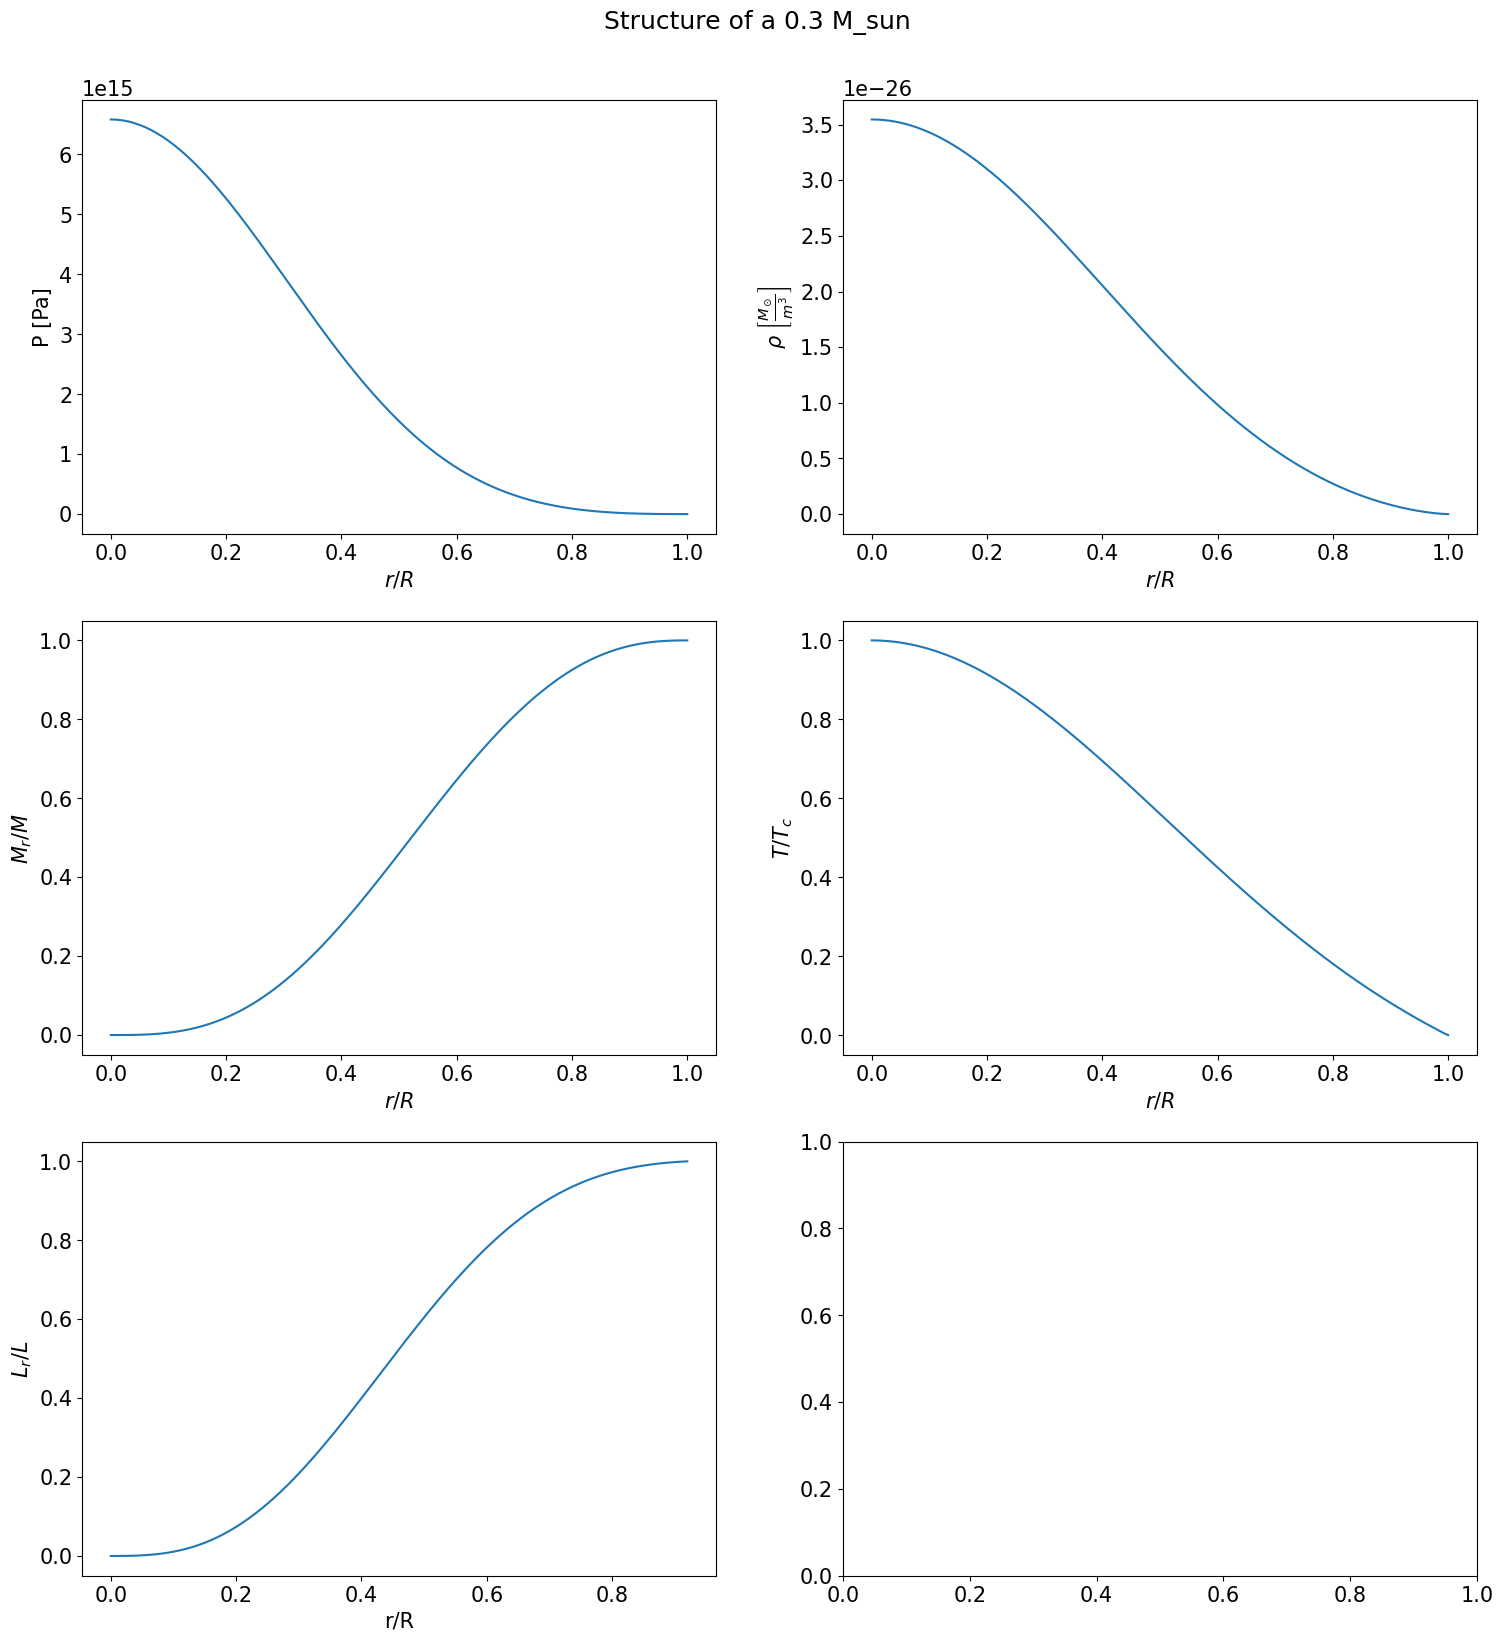

In [54]:
fig, ax = plt.subplots(3,2, figsize=(18,18))
fig.suptitle('Structure of a 0.3 M_sun')
fig.subplots_adjust(top = 0.93)

ax[0][0].plot(result1["r"]/0.33*u.R_sun, result1["p"])
ax[0][0].set_xlabel(r'$r/R$')
ax[0][0].set_ylabel('P [Pa]')

ax[0][1].plot(result1["r"]/0.33*u.R_sun, result1["rho"])
ax[0][1].set_ylabel(r'$\rho\ \left[\frac{M_\odot}{m^{3}}\right]$')
ax[0][1].set_xlabel(r'$r/R$')

ax[1][0].plot(result1["r"]/0.33*u.R_sun, result1["mr"]/0.3*u.M_sun)
ax[1][0].set_ylabel(r'${M_r}/M$')
ax[1][0].set_xlabel(r'$r/R$')

ax[1][1].plot(result1["r"]/0.33*u.R_sun, T1/T1[0])
ax[1][1].set_ylabel(r'$T/{T_c}$')
ax[1][1].set_xlabel(r'$r/R$')

ax[2][0].plot(result1["r"][:-16]/0.33*u.R_sun, L1_int/L1_int[-1])
ax[2][0].set_xlabel('r/R')
ax[2][0].set_ylabel(r'${L_r}/L$')

# 0.1 M_sun

In [70]:
m = 0.1*u.M_sun
r = 0.13*u.R_sun
mu = 4/3
rho_c = 5.99071*m / (4/3*np.pi*r**3).si
pc = 0.77014*const.G*m**2/r**4 # Ideal gas law
gamma = 5/3 # Since n=1.5
k = pc / (rho_c ** gamma).si

poly = Polytrope(k=k, gamma=gamma)
p_ism = 2.5e-12 * u.Pa

result2 = poly.integrate(rho_c, np.linspace(0, 0.13, 201)*u.R_sun, condition=p_gt_p_ism)
t2 = mu * const.m_p * result2['p'] / (result2['rho'].si * const.k_B)
energy2 = result2["energy"][:-15]

T2 = (mu * const.m_p * result2["p"] / (result2["rho"] * const.k_B)).si

dLdr2 = []
for i in range(len(energy2)):
    dLdr2.append((4*np.pi*result2["r"][i].si ** 2 * (energy2[i] * u.erg).si * result2["rho"][i].si).value)
L2_int = np.array(integrate_list(dLdr2))/10

T_eff2 = effective_T(0.13 * u.R_sun, L2_int[-2])

In [75]:
print('Q1:')

print(f'Central pressure is {result2["p"][0]}')
print(f'Central temperature is {T2[0].si}')

print('Q2:')

print(f'Luminosity is {(L2_int[-1]*u.W/const.L_sun * u.L_sun)}')
print(f'The applied effective temperature is {T_eff2}')

Q1:
Central pressure is 3.0375665548069404e+16 Pa
Central temperature is 12763785.894029729 K
Q2:
Luminosity is 0.0013904670296271634 solLum
The applied effective temperature is 3091.077929420254 K


Text(0, 0.5, '${L_r}/L$')

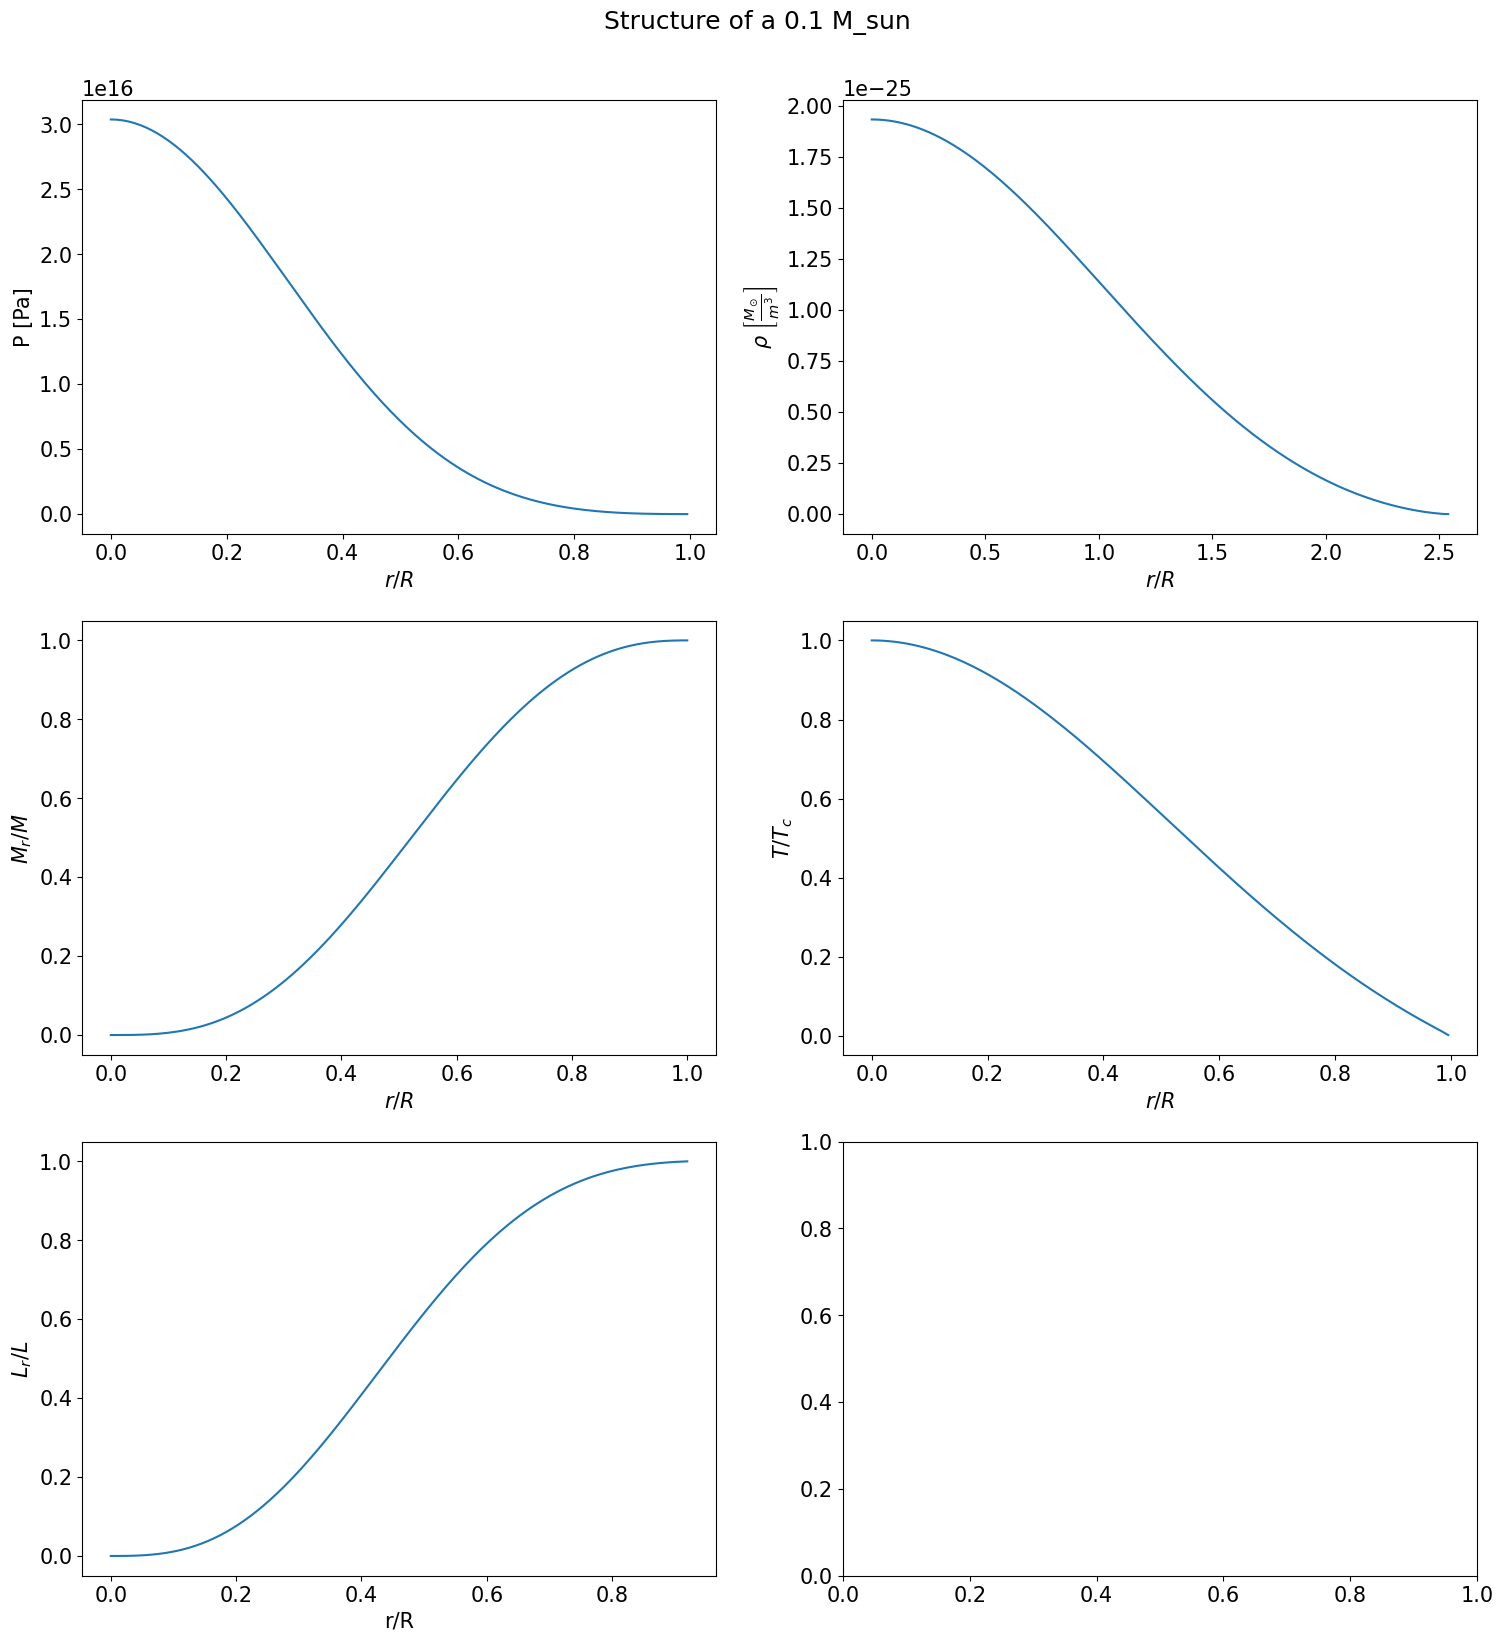

In [71]:
fig, ax = plt.subplots(3,2, figsize=(18,18))
fig.suptitle('Structure of a 0.1 M_sun')
fig.subplots_adjust(top = 0.93)

ax[0][0].plot(result2["r"]/0.13*u.R_sun, result2["p"])
ax[0][0].set_xlabel(r'$r/R$')
ax[0][0].set_ylabel('P [Pa]')

ax[0][1].plot(result1["r"]/0.13*u.R_sun, result2["rho"])
ax[0][1].set_ylabel(r'$\rho\ \left[\frac{M_\odot}{m^{3}}\right]$')
ax[0][1].set_xlabel(r'$r/R$')

ax[1][0].plot(result2["r"]/0.13*u.R_sun, result2["mr"]/0.1*u.M_sun)
ax[1][0].set_ylabel(r'${M_r}/M$')
ax[1][0].set_xlabel(r'$r/R$')

ax[1][1].plot(result2["r"]/0.13*u.R_sun, T2/T2[0])
ax[1][1].set_ylabel(r'$T/{T_c}$')
ax[1][1].set_xlabel(r'$r/R$')

ax[2][0].plot(result2["r"][:-16]/0.13*u.R_sun, L2_int/L2_int[-1])
ax[2][0].set_xlabel('r/R')
ax[2][0].set_ylabel(r'${L_r}/L$')

Q3:
The centers of smaller stars have higher central temperature and pressure but lower temperature on the surface. This means that there is a faster drop off in the temperature. Since the rate of nuclear fusion is highly sensitive to temperature, the rate of energy generation in the center would be higher in the lower mass star which makes it more luminous.